# Advanced Preparation of Financial Data

# IMPORTANCE OF OUR DATA AND ANALYSIS

Understanding pricing strategies in the context of the Initial Public Offering (IPO) process using advanced and novel methods to prepare the collected data, for further predictive analysis of the “underpricing” phenomenon.


Link for Data dictionary - https://ba-lab.fairfield.edu/user/aagarwal/files/project1-archana-s-team/DataDictionary20190115.pdf

# DATA PREPARATION STEPS

#  Importing libraries and loading data

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import seaborn as sns
from scipy.stats import zscore, skew
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from itertools import chain
import xgboost
from sklearn import metrics, model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.decomposition import PCA

from sklearn.metrics import roc_curve, confusion_matrix

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [40]:
# Code to display the data limiting to 500
pd.set_option('display.max_columns', 500)

In [41]:
raw_data = pd.read_excel('Competition1_raw_data.xlsx')
data = raw_data.copy()

In [42]:
# Code to check the first 5 rows of the dataset
data.head()

,I1,I2,I3,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3
0,AATI,ADVANCED ANALOGIC TECHNOLOGIES INC,3674,10,9.5,8.5,11.87,122,1,3.43,0.0290743,40962052,10600000,51.345,470,12719,11560,301,690,62,117,139
1,ABPI,ACCENTIA BIOPHARMACEUTICALS INC,2834,8,10,8,7.25,259,0,-1.62,-0.0133516,28869196,2400000,25.936,791,21792,19585,510,1120,71,242,237
2,ACAD,ACADIA PHARMACEUTICALS INC,2834,7,14,12,6.7,90,1,-1.24,0.020715,16845668,5000000,7.378,201,5262,4785,128,325,61,33,60
3,ACHN,ACHILLION PHARMACEUTICALS INC,2834,11.5,16,14,12.39,209,1,-0.91,0.0200231,14848637,4500000,8.526,328,8259,7574,177,509,80,59,110
4,ACLI,AMERICAN COMMERCIAL LINES INC.,4492,21,21,19,56.6,80,1,0.07,-0.0348947,30741716,8250000,632.298,572,14830,13176,336,720,67,149,167


In [43]:
# Code to check the total number of rows and columns in the initial dataset
data.shape

(682, 22)

# Identifying null values

After looking at the initial dataset, we identify that there are missing values, data discrepancies in the form of the - 
 - Quoted price range for IPO wherein higher price is lower than the lower price
 - Number of long sentences are less than the number of sentences
 - Number of words are less than the number of real words
 - Number of long words less than number of real words
 - Number of words less than number of sentences

In [44]:
# Creating a for loop for replacing the missing values('-') with 'nan'
for col in data.columns:
    data[col] = data[col].apply(lambda x: np.nan if x == '-' else x)

In [45]:
# Defining data_validation function to deal with various data discrepancies

def data_validation(row):  
    '''
    Run initially to identify rows which do not logically make sense.
    Fix the issues, and then rerun until only nulls left
    
    '''
    # If any nulls we know it's off
    ret_val = 0
    if row.isna().any():
        ret_val = 1
    
    # P(H) > P(L)
    #Higher range of price > lower range
    if row['P(H)'] < row['P(L)']:
        ret_val = 2
    
    # T4 < T1
    # Number of long sentences less than number of sentences
    elif row['T4'] > row['T1']:
        ret_val = 3
        
    # T3 < T2
    # Number of words < number of real words
    elif row['T3'] > row['T2']:
        ret_val = 4
        
    # T5 < T2
    # Number of long words < number of total words
    elif row['T5'] > row['T2']:
        ret_val = 5
        
    # T1 < T2
    # Number of words > number of sentences
    elif row['T1'] > row['T2']:
        ret_val = 6
    
    # C2, C3' in [0,1]
    # Defined as only being one of these two
    elif row['C2'] not in [0.0,1.0] and pd.notnull(row['C2']):
        ret_val = 7
    
    return ret_val

In [46]:
# Creating a new column data_updated to apply the above function
data['data_updated'] = data.apply(lambda row: data_validation(row), axis = 1)

In [47]:
data.data_updated.value_counts()

0    590
1     87
4      2
2      2
3      1
Name: data_updated, dtype: int64

We can see that there are 87 rows containing null values. Additionally, a few rows contain logic which does not make sense. 

In [48]:
#Replacing the illogical values of 2,3,4 in the data_updated_value column with 'nan'
data.loc[data['data_updated'] == 2, ['P(H)','P(L)']] = np.nan

In [49]:
data.loc[data['data_updated'] == 3, ['T4','T1']] = np.nan

In [50]:
data.loc[data['data_updated'] == 4, ['T3','T2']] = np.nan

In [51]:
data['data_updated'] = data.apply(lambda row: data_validation(row), axis = 1)

In [52]:
#Rechecking if all the values have been replaced
data.data_updated.value_counts()

0    590
1     91
4      1
Name: data_updated, dtype: int64

Data_updated column containing value as 4 seems to have more than one logical issue. In order to fix this issue, we rerun the function and check if the data is cleaned.

In [53]:
data.data_updated.value_counts()

0    590
1     91
4      1
Name: data_updated, dtype: int64

In [54]:
data.loc[data['data_updated'] == 4, ['T3','T2']] = np.nan

In [55]:
data['data_updated'] = data.apply(lambda row: data_validation(row), axis = 1)

In [56]:
#Rechecking if the issue have been fixed
data.data_updated.value_counts()

0    590
1     92
Name: data_updated, dtype: int64


# Step 2: Descriptive Statistics
- Mean/median/std/min/max/count/quartiles
- Missing Records
- Outlier Identification
    - Address Outliers
- Data Types/Fix data types

In [57]:
#Code to generate the descriptive statistics for our dataframe
data.describe().round(1)

,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3,data_updated
count,677.0,670.0,670.0,660.0,660.0,660.0,646.0,660.0,6.760000e+02,676.0,610.0,680.0,678.0,678.0,680.0,681.0,681.0,681.0,681.0,682.0
mean,13.8,15.5,13.5,25.9,149.7,0.9,1.8,0.0,4.935776e+07,12415194.2,500.5,466.0,12814.3,11377.9,294.3,679.2,68.4,120.1,144.8,0.1
std,6.1,6.6,5.8,73.2,152.8,0.3,162.7,0.0,1.043764e+08,25128554.7,1648.3,175.7,5396.8,4833.3,121.6,472.9,39.1,84.8,69.3,0.3
min,3.0,4.0,3.0,0.0,10.0,0.0,-786.2,-0.2,3.693227e+06,525000.0,0.1,132.0,3271.0,0.0,0.0,-1.0,-1.0,20.0,26.0,0.0
25%,10.0,13.0,11.0,11.0,85.0,1.0,-0.9,-0.0,1.871417e+07,5000000.0,37.2,351.8,9213.2,8135.0,212.8,462.0,45.0,73.0,100.0,0.0
50%,13.5,15.0,13.0,14.8,107.0,1.0,0.0,0.0,2.740018e+07,7398703.5,103.8,444.5,12056.0,10774.5,279.0,624.0,60.0,100.0,134.0,0.0
75%,17.0,17.0,15.0,20.5,155.2,1.0,0.5,0.0,4.980786e+07,11999999.2,331.1,551.2,15243.2,13712.0,353.2,795.0,85.0,142.0,173.0,0.0
max,85.0,135.0,108.0,1159.2,2087.0,1.0,3864.5,0.1,2.138085e+09,421233615.0,30683.0,1750.0,49056.0,43952.0,1058.0,10277.0,309.0,944.0,883.0,1.0


From the above stats, we could see that there are a lot of outliers in each column against their average values with high standard deviation.

# Identifying outliers with the help of boxplot

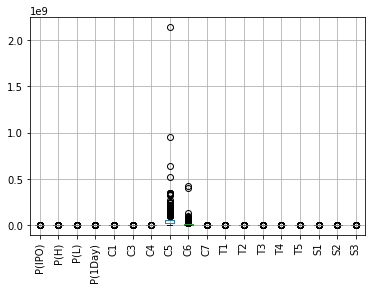

In [58]:
#Creating box plot to check the outliers excluding the columns with categorical values
data[[i for i in data.columns if i not in ['I1','I2','I3', 'C2', 'data_updated']]].boxplot()
plt.xticks(rotation=90)
plt.show()

The boxplot is not very useful as the scale is dramatically different based on the column in question. In order to properly view each of these fields we will add a scaler to bring the data within the range of 0 and 1.

In [59]:
#Defining a function to bring the scaler levels within the range of 0 and 1

def min_max_scale_col(df, cols):
    scaler = preprocessing.MinMaxScaler()
    return scaler.fit_transform(df[cols])

def min_max_scale_df(df):
    scaler = preprocessing.MinMaxScaler()
    return scaler.fit_transform(df)


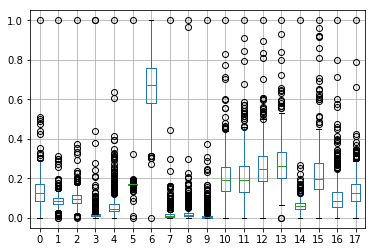

In [60]:
#Applying the above function to create a new boxplot
pd.DataFrame(min_max_scale_df(data[[i for i in data.columns if i not in ['I1','I2','I3', 'C2', 'data_updated']]])).boxplot()
plt.show()


# Checking Data Types

It is important that we check the data type for all the columns, since the datatype may be different from what it appears. This can be done using function like dtypes 

In [61]:
data.dtypes

I1               object
I2               object
I3               object
P(IPO)          float64
P(H)            float64
P(L)            float64
P(1Day)         float64
C1              float64
C2              float64
C3              float64
C4              float64
C5              float64
C6              float64
C7              float64
T1              float64
T2              float64
T3              float64
T4              float64
T5              float64
S1              float64
S2              float64
S3              float64
data_updated      int64
dtype: object

We observe that 'I3' column reflecting SIC codes for each company shows the datatype as 'Object' instead of integer. After observing the data more keenly, we see that there are 4 companies which have multiple SIC codes which changes the datatype for this column from 'float' to 'object'.

In [62]:
#Checking the columns reflecting string
data[data.I3.apply(lambda x: isinstance(x, str))]

,I1,I2,I3,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3,data_updated
174,DLB,"Dolby Laboratories, Inc.","6794, 3861, 3663, 7819",18.0,18.0,16.0,24.299999,90.0,1.0,0.47,0.020090,97362135.0,27500000.0,289.041,500.0,15288.0,14243.0,360.0,912.0,69.0,122.0,165.0,0
187,DTSI,"DTS, INC.","3651, 6794, 7819",17.0,16.0,14.0,24.920000,76.0,0.0,0.99,0.044011,13097313.0,3840000.0,41.056,339.0,8274.0,7487.0,204.0,421.0,49.0,95.0,70.0,0
499,RLD,RealD Inc.,"3663, 3861, 6794",16.0,15.0,13.0,19.510000,98.0,1.0,-0.33,0.012058,47638374.0,12500000.0,39.675,629.0,15904.0,14741.0,364.0,899.0,104.0,139.0,227.0,0
620,UPG,UNIVERSAL POWER GROUP,"7389, 5063",7.0,9.0,7.0,7.350000,101.0,0.0,0.38,-0.000171,5000000.0,3000000.0,81.275,304.0,6904.0,6234.0,147.0,287.0,29.0,61.0,66.0,0


In order to fix the issue, one we can use the following chart to see if any of the rows with more than one SIC code have a natural grouping in their values. 

<table class="wikitable sortable jquery-tablesorter">

<thead><tr>
<th class="headerSort" tabindex="0" role="columnheader button" title="Sort ascending">Range of SIC Codes
</th>
<th class="headerSort" tabindex="0" role="columnheader button" title="Sort ascending">Division
</th></tr></thead><tbody>
<tr>
<td>0100-0999
</td>
<td>Agriculture, Forestry and Fishing
</td></tr>
<tr>
<td>1000-1499
</td>
<td>Mining
</td></tr>
<tr>
<td>1500-1799
</td>
<td>Construction
</td></tr>
<tr>
<td>1800-1999
</td>
<td>not used
</td></tr>
<tr>
<td>2000-3999
</td>
<td>Manufacturing
</td></tr>
<tr>
<td>4000-4999
</td>
<td>Transportation, Communications, Electric, Gas and Sanitary service
</td></tr>
<tr>
<td>5000-5199
</td>
<td>Wholesale Trade
</td></tr>
<tr>
<td>5200-5999
</td>
<td>Retail Trade
</td></tr>
<tr>
<td>6000-6799
</td>
<td>Finance, Insurance and Real Estate
</td></tr>
<tr>
<td>7000-8999
</td>
<td>Services
</td></tr>
<tr>
<td>9100-9729
</td>
<td>Public Administration
</td></tr>
<tr>
<td>9900-9999
</td>
<td>Nonclassifiable
</td></tr></tbody><tfoot></tfoot></table>

Both Dolby Laboratories Inc. and RealD Inc. have some resemblence of agreement in the SIC codes indicating mostly Manufacturing content. In order to represent this, these two rows will have their I3 column assigned to a value in the Manufacturing range.

The other two rows do not have the same SIC code overlap and will be set as a code in the "Nonclassifiable" range to avoid making assumptions.

In [63]:
#Applying the SIC division to specific rows mentioned above
data.loc[174, ['I3']] = 3500
data.loc[499, ['I3']] = 3500

data.loc[187, ['I3']] = 9999
data.loc[620, ['I3']] = 9999

After applying the above function, we should see that column 'I3' no longer has any string values. 

In [64]:
#Validating the I3 column to check if there are any strings
data[data.I3.apply(lambda x: isinstance(x, str))]

,I1,I2,I3,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3,data_updated


In [65]:
data['I3'] = data['I3'].astype(np.float64)

In [66]:
#Rechecking the data type for all the columns are aligned as required
data.dtypes

I1               object
I2               object
I3              float64
P(IPO)          float64
P(H)            float64
P(L)            float64
P(1Day)         float64
C1              float64
C2              float64
C3              float64
C4              float64
C5              float64
C6              float64
C7              float64
T1              float64
T2              float64
T3              float64
T4              float64
T5              float64
S1              float64
S2              float64
S3              float64
data_updated      int64
dtype: object

# Identifying the 'Null' values 

In [67]:
#code to identify the sum of null values
pd.isna(data).sum()

I1               0
I2               0
I3               8
P(IPO)           5
P(H)            12
P(L)            12
P(1Day)         22
C1              22
C2              22
C3              36
C4              22
C5               6
C6               6
C7              72
T1               2
T2               4
T3               4
T4               2
T5               1
S1               1
S2               1
S3               1
data_updated     0
dtype: int64

'Null'values will be handled using imputation methods in the next step.

# Step 3: Data Imputation
- Address null values dependent on the type of value in question
- Create a seperate column which shows whether or not imputation occurred

Imputation is the process of replacing missing data with substituted values using different techniques. We would be using mean/median/mode values to replace the missing data.This works by calculating the mean/median of the non-missing values in a column and then replacing the missing values within each column separately and independently from the others. It can only be used with numeric data.

In [69]:
#Columns which need imputation
null_cols = pd.isna(data).sum()
null_cols = null_cols[null_cols.values != 0]
null_cols

I3          8
P(IPO)      5
P(H)       12
P(L)       12
P(1Day)    22
C1         22
C2         22
C3         36
C4         22
C5          6
C6          6
C7         72
T1          2
T2          4
T3          4
T4          2
T5          1
S1          1
S2          1
S3          1
dtype: int64

In [71]:
#Excluding columns which are required for calculating the target variables starting with 'P' i.e P(IPO),P(H),P(L),P(1Day)
data = data[(~pd.isna(data['P(IPO)'])) & (~pd.isna(data['P(H)'])) & (~pd.isna(data['P(L)'])) & (~pd.isna(data['P(1Day)']))]

In [72]:
#Rechecking the columns which need imputation
null_cols = pd.isna(data).sum()
null_cols = null_cols[null_cols.values != 0]
null_cols

C3    23
C7    60
T2     2
T3     2
dtype: int64

It appears that the items with null fields needed for the target variable constituted much of the null values across other columns. We only need to fix four now.

A look at histograms and review boxplots to get a better view of what to do for remaining null fields.

/opt/tljh/user/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


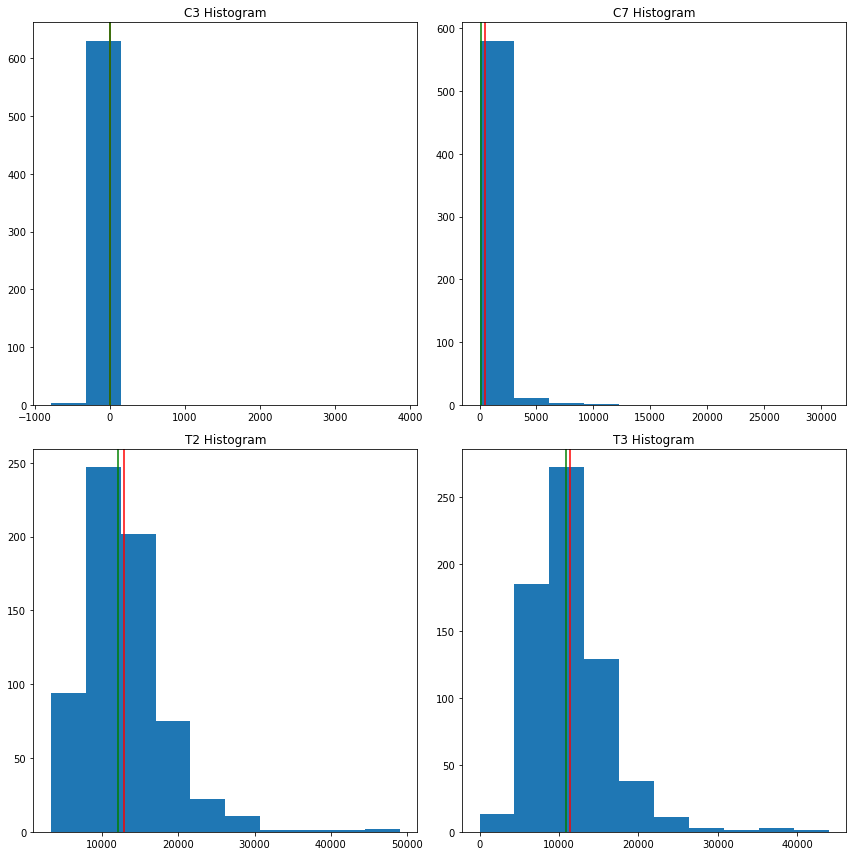

In [73]:
#Histograms to check the distribution of values in the columns
fig, axs = plt.subplots(2, 2, tight_layout=True, figsize=(12,12))

x1 = data['C3'].dropna()
x2 = data['C7'].dropna()
x3 = data['T2'].dropna()
x4 = data['T3'].dropna()

axs[0,0].hist(x1)
axs[0,0].axvline(x1.mean(), color = 'red')
axs[0,0].axvline(x1.median(), color = 'green')
axs[0,0].set_title('C3 Histogram')

axs[0,1].hist(x2)
axs[0,1].axvline(x2.mean(), color = 'red')
axs[0,1].axvline(x2.median(), color = 'green')
axs[0,1].set_title('C7 Histogram')

axs[1,0].hist(x3)
axs[1,0].axvline(x3.mean(), color = 'red')
axs[1,0].axvline(x3.median(), color = 'green')
axs[1,0].set_title('T2 Histogram')

axs[1,1].hist(x4)
axs[1,1].axvline(x4.mean(), color = 'red')
axs[1,1].axvline(x4.median(), color = 'green')
axs[1,1].set_title('T3 Histogram')

plt.show()

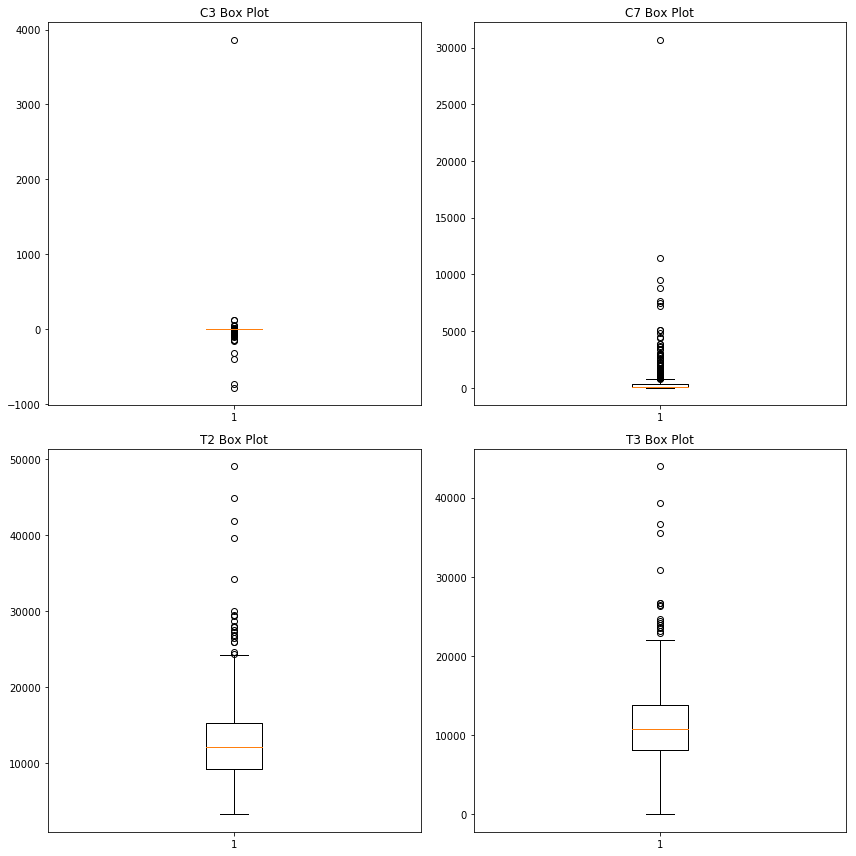

In [74]:
#Boxplots to view the spread of data
fig, axs = plt.subplots(2, 2, tight_layout=True, figsize=(12,12))

axs[0,0].boxplot(x1)
axs[0,0].set_title('C3 Box Plot')

axs[0,1].boxplot(x2)
axs[0,1].set_title('C7 Box Plot')

axs[1,0].boxplot(x3)
axs[1,0].set_title('T2 Box Plot')

axs[1,1].boxplot(x4)
axs[1,1].set_title('T3 Box Plot')

plt.show()

From the graphs above we see that the difference between mean and median appears to be small, but the amount of outliers makes median a safer method for imputation for each of these fields.

In [77]:
#Defining a function to impute missing values using mean/median/mode

def impute_nulls_df(df, col, replace_val):
    '''
    params:
    
    df - dataframe containing nulls
    col - columns with nulls to replace
    replace_val - options: 'mean', 'median', 'mode'
    
    Example:

    imputed_data = impute_nulls(data, C1, 'mean')
    '''
    
    if replace_val not in ['mean','median','mode']:
        print('requires one of the following: mean, median, mode')
        return
    
    elif replace_val == 'mean':
        df[col + '_imputed'] = df[col].fillna(df[col].mean())
    elif replace_val == 'median':
        df[col + '_imputed'] = df[col].fillna(df[col].median())
    elif replace_val == 'mode':
        df[col + '_imputed'] = df[col].fillna(df[col].mode().values[0])
        
    return df

In [79]:
#Creating a dictionary for column name and the type of imputation for each column
imputing = {
    'C3': 'median',
    'C7': 'median',
    'T2': 'median',
    'T3': 'median'
 }

# Creating a loop and using the function above to create new imputed columns
data_w_imputed = data.copy()

for key in imputing.keys():
    data_w_imputed = impute_nulls_df(data_w_imputed, key, imputing[key])

In [80]:
#Check to make sure only the original four columns have null values and the imputed ones have none
pd.isna(data_w_imputed).sum()

I1               0
I2               0
I3               0
P(IPO)           0
P(H)             0
P(L)             0
P(1Day)          0
C1               0
C2               0
C3              23
C4               0
C5               0
C6               0
C7              60
T1               0
T2               2
T3               2
T4               0
T5               0
S1               0
S2               0
S3               0
data_updated     0
C3_imputed       0
C7_imputed       0
T2_imputed       0
T3_imputed       0
dtype: int64

In [81]:
#Checking the new imputed columns are a part of the dataframe
data_w_imputed.head()

,I1,I2,I3,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3,data_updated,C3_imputed,C7_imputed,T2_imputed,T3_imputed
0,AATI,ADVANCED ANALOGIC TECHNOLOGIES INC,3674.0,10.0,9.5,8.5,11.870000,122.0,1.0,3.43,0.029074,40962052.0,10600000.0,51.345,470.0,12719.0,11560.0,301.0,690.0,62.0,117.0,139.0,0,3.43,51.345,12719.0,11560.0
1,ABPI,ACCENTIA BIOPHARMACEUTICALS INC,2834.0,8.0,10.0,8.0,7.250000,259.0,0.0,-1.62,-0.013352,28869196.0,2400000.0,25.936,791.0,21792.0,19585.0,510.0,1120.0,71.0,242.0,237.0,0,-1.62,25.936,21792.0,19585.0
2,ACAD,ACADIA PHARMACEUTICALS INC,2834.0,7.0,14.0,12.0,6.700000,90.0,1.0,-1.24,0.020715,16845668.0,5000000.0,7.378,201.0,5262.0,4785.0,128.0,325.0,61.0,33.0,60.0,0,-1.24,7.378,5262.0,4785.0
3,ACHN,ACHILLION PHARMACEUTICALS INC,2834.0,11.5,16.0,14.0,12.390000,209.0,1.0,-0.91,0.020023,14848637.0,4500000.0,8.526,328.0,8259.0,7574.0,177.0,509.0,80.0,59.0,110.0,0,-0.91,8.526,8259.0,7574.0
4,ACLI,AMERICAN COMMERCIAL LINES INC.,4492.0,21.0,21.0,19.0,56.599998,80.0,1.0,0.07,-0.034895,30741716.0,8250000.0,632.298,572.0,14830.0,13176.0,336.0,720.0,67.0,149.0,167.0,0,0.07,632.298,14830.0,13176.0


In [82]:
#Dropping the original columns with null values
data_w_imputed = data_w_imputed.drop(columns=['C3','C7','T2','T3'])

In [84]:
#Checking if the columns are dropped
data_w_imputed.head()

,I1,I2,I3,P(IPO),P(H),P(L),P(1Day),C1,C2,C4,C5,C6,T1,T4,T5,S1,S2,S3,data_updated,C3_imputed,C7_imputed,T2_imputed,T3_imputed
0,AATI,ADVANCED ANALOGIC TECHNOLOGIES INC,3674.0,10.0,9.5,8.5,11.870000,122.0,1.0,0.029074,40962052.0,10600000.0,470.0,301.0,690.0,62.0,117.0,139.0,0,3.43,51.345,12719.0,11560.0
1,ABPI,ACCENTIA BIOPHARMACEUTICALS INC,2834.0,8.0,10.0,8.0,7.250000,259.0,0.0,-0.013352,28869196.0,2400000.0,791.0,510.0,1120.0,71.0,242.0,237.0,0,-1.62,25.936,21792.0,19585.0
2,ACAD,ACADIA PHARMACEUTICALS INC,2834.0,7.0,14.0,12.0,6.700000,90.0,1.0,0.020715,16845668.0,5000000.0,201.0,128.0,325.0,61.0,33.0,60.0,0,-1.24,7.378,5262.0,4785.0
3,ACHN,ACHILLION PHARMACEUTICALS INC,2834.0,11.5,16.0,14.0,12.390000,209.0,1.0,0.020023,14848637.0,4500000.0,328.0,177.0,509.0,80.0,59.0,110.0,0,-0.91,8.526,8259.0,7574.0
4,ACLI,AMERICAN COMMERCIAL LINES INC.,4492.0,21.0,21.0,19.0,56.599998,80.0,1.0,-0.034895,30741716.0,8250000.0,572.0,336.0,720.0,67.0,149.0,167.0,0,0.07,632.298,14830.0,13176.0


# Step 3B: Seperate Categorical and Continuous Fields, drop non-imputed columns

In [85]:
#Creating seperate dataframe for categorical columns
cat_fields = ['I1','I2', 'I3','C2','data_updated']
cat_data = data_w_imputed[cat_fields]

In [86]:
#Verifying the new dataframe
cat_data.head()

,I1,I2,I3,C2,data_updated
0,AATI,ADVANCED ANALOGIC TECHNOLOGIES INC,3674.0,1.0,0
1,ABPI,ACCENTIA BIOPHARMACEUTICALS INC,2834.0,0.0,0
2,ACAD,ACADIA PHARMACEUTICALS INC,2834.0,1.0,0
3,ACHN,ACHILLION PHARMACEUTICALS INC,2834.0,1.0,0
4,ACLI,AMERICAN COMMERCIAL LINES INC.,4492.0,1.0,0


In [87]:
#Creating seperate dataframe for continous columns
cont_data = data_w_imputed[['I1'] + list(set(data_w_imputed.columns) - set(cat_data.columns))]

In [88]:
#Verifying the new dataframe
cont_data.head()

,I1,P(1Day),P(L),P(H),S1,C7_imputed,T5,T3_imputed,T2_imputed,C1,C5,P(IPO),C4,S2,S3,C3_imputed,T4,T1,C6
0,AATI,11.870000,8.5,9.5,62.0,51.345,690.0,11560.0,12719.0,122.0,40962052.0,10.0,0.029074,117.0,139.0,3.43,301.0,470.0,10600000.0
1,ABPI,7.250000,8.0,10.0,71.0,25.936,1120.0,19585.0,21792.0,259.0,28869196.0,8.0,-0.013352,242.0,237.0,-1.62,510.0,791.0,2400000.0
2,ACAD,6.700000,12.0,14.0,61.0,7.378,325.0,4785.0,5262.0,90.0,16845668.0,7.0,0.020715,33.0,60.0,-1.24,128.0,201.0,5000000.0
3,ACHN,12.390000,14.0,16.0,80.0,8.526,509.0,7574.0,8259.0,209.0,14848637.0,11.5,0.020023,59.0,110.0,-0.91,177.0,328.0,4500000.0
4,ACLI,56.599998,19.0,21.0,67.0,632.298,720.0,13176.0,14830.0,80.0,30741716.0,21.0,-0.034895,149.0,167.0,0.07,336.0,572.0,8250000.0


Note:The ID field of 'I1' will be kept in both the dataframes (continuous and categorical) in order to merge as needed.

# Step 4: Create values outlined in Data Dictionary
- T1-T5 as ratios
- S1-S3 as ratios
- C3', C5', C6'
- Y1, Y2

Reference here: https://github.com/fairfield-university-ba545/project1-archana-s-team/blob/master/DataDictionary20190115.pdf

In [89]:
# Calculating various ratios to determine words per sentence, short and long sentences
cont_data['words_per_sentence'] = cont_data.T2_imputed / cont_data.T1
cont_data['real_word_per'] = cont_data.T3_imputed / cont_data.T2_imputed
cont_data['non_real_word_per'] = (cont_data.T2_imputed - cont_data.T3_imputed) / cont_data.T2_imputed
cont_data['short_sentences'] = cont_data.T1 - cont_data.T4
cont_data['short_sentences_per'] = cont_data.short_sentences / cont_data.T1
cont_data['long_sentences_per'] = cont_data.T4 / cont_data.T1
cont_data['long_words_per'] = cont_data.T5 / cont_data.T2_imputed

/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [90]:
#Calculating the percent of positive, negative and uncertain words
cont_data['pos_words_percent'] = cont_data.S1 / (cont_data.S1 + cont_data.S2 + cont_data.S3)
cont_data['neg_words_percent'] = cont_data.S2 / (cont_data.S1 + cont_data.S2 + cont_data.S3)
cont_data['uncertain_words_percent'] = cont_data.S3 / (cont_data.S1 + cont_data.S2 + cont_data.S3)


In [91]:
#Calculating different ratios against the total shares
cont_data['total_shares'] = cont_data.C5 + cont_data.C6
cont_data['sales_per_share'] = cont_data.C7_imputed/cont_data.total_shares
cont_data['outstanding_share_per'] = cont_data.C5/cont_data.total_shares
cont_data['offering_share_per'] = cont_data.C6/cont_data.total_shares

In [92]:
#Calculating the control variables and target variables 
cont_data['C3_prime'] = cont_data.C3_imputed.apply(lambda x: 1 if x>0 else 0)
cont_data['C5_prime'] = cont_data['C5']/ cont_data['C6']
cont_data['P(mid)'] = (cont_data['P(H)'] + cont_data['P(L)'])/2
cont_data['C6_prime'] = (cont_data['P(IPO)'] - cont_data['P(mid)'])/cont_data['P(mid)']*100
cont_data['Y1'] = cont_data.apply(lambda row: 1 if row['P(IPO)'] < row['P(mid)'] else 0, axis = 1)
cont_data['Y2'] = cont_data.apply(lambda row: 1 if row['P(IPO)'] < row['P(1Day)'] else 0, axis = 1)

In [100]:
#Verifying the addition of different columns to the continous dataframe
cont_data.head()

,I1,P(1Day),P(L),P(H),S1,C7_imputed,T5,T3_imputed,T2_imputed,C1,C5,P(IPO),C4,S2,S3,C3_imputed,T4,T1,C6,words_per_sentence,real_word_per,non_real_word_per,short_sentences,short_sentences_per,long_sentences_per,long_words_per,pos_words_percent,neg_words_percent,uncertain_words_percent,total_shares,sales_per_share,outstanding_share_per,offering_share_per,C3_prime,C5_prime,P(mid),C6_prime,Y1,Y2
0,AATI,11.870000,8.5,9.5,62.0,51.345,690.0,11560.0,12719.0,122.0,40962052.0,10.0,0.029074,117.0,139.0,3.43,301.0,470.0,10600000.0,27.061702,0.908876,0.091124,169.0,0.359574,0.640426,0.054250,0.194969,0.367925,0.437107,51562052.0,9.957905e-07,0.794422,0.205578,1,3.864345,9.0,11.111111,0,1
1,ABPI,7.250000,8.0,10.0,71.0,25.936,1120.0,19585.0,21792.0,259.0,28869196.0,8.0,-0.013352,242.0,237.0,-1.62,510.0,791.0,2400000.0,27.549937,0.898724,0.101276,281.0,0.355247,0.644753,0.051395,0.129091,0.440000,0.430909,31269196.0,8.294425e-07,0.923247,0.076753,0,12.028832,9.0,-11.111111,1,0
2,ACAD,6.700000,12.0,14.0,61.0,7.378,325.0,4785.0,5262.0,90.0,16845668.0,7.0,0.020715,33.0,60.0,-1.24,128.0,201.0,5000000.0,26.179104,0.909350,0.090650,73.0,0.363184,0.636816,0.061764,0.396104,0.214286,0.389610,21845668.0,3.377329e-07,0.771122,0.228878,0,3.369134,13.0,-46.153846,1,0
3,ACHN,12.390000,14.0,16.0,80.0,8.526,509.0,7574.0,8259.0,209.0,14848637.0,11.5,0.020023,59.0,110.0,-0.91,177.0,328.0,4500000.0,25.179878,0.917060,0.082940,151.0,0.460366,0.539634,0.061630,0.321285,0.236948,0.441767,19348637.0,4.406512e-07,0.767425,0.232575,0,3.299697,15.0,-23.333333,1,1
4,ACLI,56.599998,19.0,21.0,67.0,632.298,720.0,13176.0,14830.0,80.0,30741716.0,21.0,-0.034895,149.0,167.0,0.07,336.0,572.0,8250000.0,25.926573,0.888469,0.111531,236.0,0.412587,0.587413,0.048550,0.174935,0.389034,0.436031,38991716.0,1.621621e-05,0.788417,0.211583,1,3.726269,20.0,5.000000,0,1


# Step 4B: Binning the SIC Codes and creating a seperate dataframe for Target Variables

Binning is a way to group a number of more or less continuous values into a smaller number of "bins".

SIC codes chart added earlier needs to be binned into various buckets to simplify and compress the data. 

In [95]:
#Creating a definition for binning the SIC codes

def bin_sic(val):
    try:
        val = int(val)
    except Exception as e:
        return 'Other'
    if val <= 999:
        return 'Agriculture, Forestry and Fishing'
    if val <= 1499:
        return 'Mining'
    if val <= 1799:
        return 'Construction'
    if val <= 1999:
        return 'Other'
    if val <= 3999:
        return 'Manufacturing'
    if val <= 4999:
        return 'Transportation, Communications, Electric, Gas and Sanitary service'
    if val <= 5199:
        return 'Wholesale Trade'
    if val <= 5999:
        return 'Retail Trade'
    if val <= 6799:
        return 'Finance, Insurance and Real Estate'
    if val <= 8999:
        return 'Services'
    if val <= 9729:
        return 'Public Administration'
    return 'Other'
    

In [96]:
#Applying the above definition to continous dataframe
cat_data['industry_bin'] = cat_data['I3'].apply(bin_sic)
cat_data['industry_bin'] = cat_data['industry_bin'].astype('category')
cat_data['C3_prime'] = cont_data['C3_prime']

/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [101]:
#Verifying the binning
cat_data.head()

,I1,I2,I3,C2,data_updated,industry_bin,C3_prime
0,AATI,ADVANCED ANALOGIC TECHNOLOGIES INC,3674.0,1.0,0,Manufacturing,1
1,ABPI,ACCENTIA BIOPHARMACEUTICALS INC,2834.0,0.0,0,Manufacturing,0
2,ACAD,ACADIA PHARMACEUTICALS INC,2834.0,1.0,0,Manufacturing,0
3,ACHN,ACHILLION PHARMACEUTICALS INC,2834.0,1.0,0,Manufacturing,0
4,ACLI,AMERICAN COMMERCIAL LINES INC.,4492.0,1.0,0,"Transportation, Communications, Electric, Gas ...",1


In [97]:
#Creating a seperate dataframe for target variables
target_df = cont_data[['I1','Y1','Y2']]

In [98]:
#Checking the new dataframe
target_df.head()

,I1,Y1,Y2
0,AATI,0,1
1,ABPI,1,0
2,ACAD,1,0
3,ACHN,1,1
4,ACLI,0,1


In [102]:
#Dropping the columns which were used to create various ratios in step 4
continuous_df = cont_data.copy()
continuous_df = continuous_df.drop(columns = ['S1','S2','S3','T1','T2_imputed','T3_imputed',
                                              'T4','T5', 'P(IPO)', 'P(L)', 'P(H)', 'P(1Day)', 'P(mid)',
                                             'C5','C6','C3_prime', 'Y1','Y2'])
continuous_df.head()

,I1,C7_imputed,C1,C4,C3_imputed,words_per_sentence,real_word_per,non_real_word_per,short_sentences,short_sentences_per,long_sentences_per,long_words_per,pos_words_percent,neg_words_percent,uncertain_words_percent,total_shares,sales_per_share,outstanding_share_per,offering_share_per,C5_prime,C6_prime
0,AATI,51.345,122.0,0.029074,3.43,27.061702,0.908876,0.091124,169.0,0.359574,0.640426,0.054250,0.194969,0.367925,0.437107,51562052.0,9.957905e-07,0.794422,0.205578,3.864345,11.111111
1,ABPI,25.936,259.0,-0.013352,-1.62,27.549937,0.898724,0.101276,281.0,0.355247,0.644753,0.051395,0.129091,0.440000,0.430909,31269196.0,8.294425e-07,0.923247,0.076753,12.028832,-11.111111
2,ACAD,7.378,90.0,0.020715,-1.24,26.179104,0.909350,0.090650,73.0,0.363184,0.636816,0.061764,0.396104,0.214286,0.389610,21845668.0,3.377329e-07,0.771122,0.228878,3.369134,-46.153846
3,ACHN,8.526,209.0,0.020023,-0.91,25.179878,0.917060,0.082940,151.0,0.460366,0.539634,0.061630,0.321285,0.236948,0.441767,19348637.0,4.406512e-07,0.767425,0.232575,3.299697,-23.333333
4,ACLI,632.298,80.0,-0.034895,0.07,25.926573,0.888469,0.111531,236.0,0.412587,0.587413,0.048550,0.174935,0.389034,0.436031,38991716.0,1.621621e-05,0.788417,0.211583,3.726269,5.000000


In [103]:
#Dropping the columns from categorical df
categorical_df = cat_data.copy()
categorical_df = categorical_df.drop(columns = ['I3','I2'])
categorical_df.head()

,I1,C2,data_updated,industry_bin,C3_prime
0,AATI,1.0,0,Manufacturing,1
1,ABPI,0.0,0,Manufacturing,0
2,ACAD,1.0,0,Manufacturing,0
3,ACHN,1.0,0,Manufacturing,0
4,ACLI,1.0,0,"Transportation, Communications, Electric, Gas ...",1


Saving all the dataframes as 'csv' file

In [104]:
categorical_df.to_csv('categorical_df.csv')
continuous_df.to_csv('continuous_df.csv')
target_df.to_csv('target_df.csv')

# Step 5: Outlier Treatment using IQR

In [108]:
#Define a function to check the values higher or lower than the IQR*1.5
def interquartile_range_replacement(df, col):
    '''
    Use interquartile range to address outliers and update columns showing those we augmented to reflect the changes made
    '''
    quartile_data = df[col].describe()
    q1 = quartile_data['25%']
    q3 = quartile_data['75%']
    iqr = q3 - q1
    high = quartile_data['50%'] + (1.5 * iqr)
    low = quartile_data['50%'] - (1.5 * iqr)
    
    outliers_augmented = df[col].apply(lambda x: low if x < low else (high if x > high else x))
    
    df[col + '_iqr_standardized'] = outliers_augmented
    return df

In [109]:
#Applying the function to the continous df
cont_iqr_standardized = continuous_df.copy()
for i in [col for col in list(cont_iqr_standardized.columns[1:])]:
    cont_iqr_standardized = interquartile_range_replacement(cont_iqr_standardized, i)

In [111]:
#Checking the values
cont_iqr_standardized.head()

,I1,C7_imputed,C1,C4,C3_imputed,words_per_sentence,real_word_per,non_real_word_per,short_sentences,short_sentences_per,long_sentences_per,long_words_per,pos_words_percent,neg_words_percent,uncertain_words_percent,total_shares,sales_per_share,outstanding_share_per,offering_share_per,C5_prime,C6_prime,C7_imputed_iqr_standardized,C1_iqr_standardized,C4_iqr_standardized,C3_imputed_iqr_standardized,words_per_sentence_iqr_standardized,real_word_per_iqr_standardized,non_real_word_per_iqr_standardized,short_sentences_iqr_standardized,short_sentences_per_iqr_standardized,long_sentences_per_iqr_standardized,long_words_per_iqr_standardized,pos_words_percent_iqr_standardized,neg_words_percent_iqr_standardized,uncertain_words_percent_iqr_standardized,total_shares_iqr_standardized,sales_per_share_iqr_standardized,outstanding_share_per_iqr_standardized,offering_share_per_iqr_standardized,C5_prime_iqr_standardized,C6_prime_iqr_standardized
0,AATI,51.345,122.0,0.029074,3.43,27.061702,0.908876,0.091124,169.0,0.359574,0.640426,0.054250,0.194969,0.367925,0.437107,51562052.0,9.957905e-07,0.794422,0.205578,3.864345,11.111111,51.34500,122.0,0.029074,1.81875,27.061702,0.908876,0.091124,169.0,0.359574,0.640426,0.054250,0.194969,0.367925,0.437107,51562052.0,9.957905e-07,0.794422,0.205578,3.864345,11.111111
1,ABPI,25.936,259.0,-0.013352,-1.62,27.549937,0.898724,0.101276,281.0,0.355247,0.644753,0.051395,0.129091,0.440000,0.430909,31269196.0,8.294425e-07,0.923247,0.076753,12.028832,-11.111111,25.93600,212.0,-0.013352,-1.62000,27.549937,0.898724,0.101276,281.0,0.355247,0.644753,0.051395,0.129091,0.440000,0.430909,31269196.0,8.294425e-07,0.921929,0.078071,6.737477,-11.111111
2,ACAD,7.378,90.0,0.020715,-1.24,26.179104,0.909350,0.090650,73.0,0.363184,0.636816,0.061764,0.396104,0.214286,0.389610,21845668.0,3.377329e-07,0.771122,0.228878,3.369134,-46.153846,7.37800,90.0,0.020715,-1.24000,26.179104,0.909350,0.090650,73.0,0.363184,0.636816,0.061764,0.306985,0.214286,0.389610,21845668.0,3.377329e-07,0.771122,0.228878,3.369134,-38.941208
3,ACHN,8.526,209.0,0.020023,-0.91,25.179878,0.917060,0.082940,151.0,0.460366,0.539634,0.061630,0.321285,0.236948,0.441767,19348637.0,4.406512e-07,0.767425,0.232575,3.299697,-23.333333,8.52600,209.0,0.020023,-0.91000,25.179878,0.917060,0.082940,151.0,0.460366,0.539634,0.061630,0.306985,0.236948,0.441767,19348637.0,4.406512e-07,0.767425,0.232575,3.299697,-23.333333
4,ACLI,632.298,80.0,-0.034895,0.07,25.926573,0.888469,0.111531,236.0,0.412587,0.587413,0.048550,0.174935,0.389034,0.436031,38991716.0,1.621621e-05,0.788417,0.211583,3.726269,5.000000,496.56275,80.0,-0.034895,0.07000,25.926573,0.888469,0.111531,236.0,0.412587,0.587413,0.048550,0.174935,0.389034,0.436031,38991716.0,1.157498e-05,0.788417,0.211583,3.726269,5.000000


# Step 6: Data Standardization

## Continuous Values
- Min-Max Scaling


## Categorical
- Binning
- Identify viable categories (create as few as possible)
- One-hot-encode 

In [112]:
#Standardizing the continuous values using Min-Max Scaling
cont_min_max_scaled = pd.DataFrame(min_max_scale_df(cont_iqr_standardized[cont_iqr_standardized.columns.tolist()[1:]]), 
             columns = cont_iqr_standardized.columns.tolist()[1:])
cont_min_max_scaled['I1'] = cont_iqr_standardized['I1'].values
cont_min_max_scaled.head()

,C7_imputed,C1,C4,C3_imputed,words_per_sentence,real_word_per,non_real_word_per,short_sentences,short_sentences_per,long_sentences_per,long_words_per,pos_words_percent,neg_words_percent,uncertain_words_percent,total_shares,sales_per_share,outstanding_share_per,offering_share_per,C5_prime,C6_prime,C7_imputed_iqr_standardized,C1_iqr_standardized,C4_iqr_standardized,C3_imputed_iqr_standardized,words_per_sentence_iqr_standardized,real_word_per_iqr_standardized,non_real_word_per_iqr_standardized,short_sentences_iqr_standardized,short_sentences_per_iqr_standardized,long_sentences_per_iqr_standardized,long_words_per_iqr_standardized,pos_words_percent_iqr_standardized,neg_words_percent_iqr_standardized,uncertain_words_percent_iqr_standardized,total_shares_iqr_standardized,sales_per_share_iqr_standardized,outstanding_share_per_iqr_standardized,offering_share_per_iqr_standardized,C5_prime_iqr_standardized,C6_prime_iqr_standardized,I1
0,0.001671,0.053924,0.749962,0.169794,0.372945,0.944727,0.055273,0.200306,0.224992,0.775008,0.580726,0.470416,0.457657,0.507764,0.017940,0.011705,0.745692,0.254308,0.035990,0.478927,0.103267,0.554455,0.646105,1.000000,0.524304,0.650533,0.349467,0.526749,0.458866,0.541134,0.586770,0.469847,0.569242,0.464101,0.523850,0.085818,0.521728,0.478272,0.522171,0.684926,AATI
1,0.000843,0.119884,0.583748,0.168708,0.394163,0.934175,0.065825,0.371560,0.219755,0.780245,0.550219,0.314935,0.601349,0.495247,0.009994,0.009744,0.913135,0.086865,0.118042,0.348659,0.052090,1.000000,0.335391,0.054639,0.564129,0.521883,0.478117,0.987654,0.443639,0.556361,0.480447,0.158061,0.813082,0.441796,0.291806,0.071443,1.000000,0.000000,1.000000,0.380833,ABPI
2,0.000238,0.038517,0.717213,0.168790,0.334588,0.945220,0.054780,0.053517,0.229360,0.770640,0.661030,0.945124,0.151358,0.411846,0.006303,0.003949,0.715407,0.284593,0.031013,0.143236,0.014711,0.396040,0.584885,0.159107,0.452311,0.656534,0.343466,0.131687,0.471565,0.528435,0.866645,1.000000,0.049463,0.293168,0.184050,0.028953,0.434328,0.565672,0.439812,0.000000,ACAD
3,0.000275,0.095811,0.714502,0.168861,0.291162,0.953234,0.046766,0.172783,0.346964,0.653036,0.659600,0.768541,0.196538,0.517175,0.005325,0.005162,0.710602,0.289398,0.030315,0.277011,0.017024,0.985149,0.579818,0.249828,0.370805,0.754237,0.245763,0.452675,0.813476,0.186524,0.861660,1.000000,0.126132,0.480873,0.155497,0.037847,0.420464,0.579536,0.428264,0.213581,ACHN
4,0.020605,0.033702,0.499347,0.169072,0.323613,0.923515,0.076485,0.302752,0.289146,0.710854,0.519817,0.423133,0.499742,0.505592,0.013018,0.191097,0.737886,0.262114,0.034602,0.443103,1.000000,0.346535,0.177617,0.519244,0.431712,0.391930,0.608070,0.802469,0.645379,0.354621,0.374488,0.375031,0.640658,0.460230,0.380111,1.000000,0.499201,0.500799,0.499207,0.601301,ACLI


# Binning

The original dataset had SIC codes which was in the form of integer variable, after which it was converted to categorical variable by binning it into 10 different industry buckets. Since few buckets had very companies, these are re-binned to  smoothen the data.

In [113]:
#Binning the industry_bins column from categorical df to fewer buckets 
def combine_industry_col(val):
    if val in ['Mining','Finance, Insurance and Real Estate', 'Construction', 'Agriculture, Forestry and Fishing']:
        return 'Other'
    elif val == 'Mining':
        return 'Other'
    elif val in ['Retail Trade','Wholesale Trade', 'Transportation, Communications, Electric, Gas and Sanitary service']:
        return 'Other'
    else:
        return val

In [116]:
#Applying the above function to continuous df
categorical_df['industry_bin'] = categorical_df['industry_bin'].apply(combine_industry_col)

In [117]:
#Checking the results
categorical_df.head()

,I1,C2,data_updated,industry_bin,C3_prime
0,AATI,1.0,0,Manufacturing,1
1,ABPI,0.0,0,Manufacturing,0
2,ACAD,1.0,0,Manufacturing,0
3,ACHN,1.0,0,Manufacturing,0
4,ACLI,1.0,0,Other,1


# One-hot encode

One hot encoding is a representation of categorical variables as binary vectors.This first requires that the categorical values be mapped to integer values.Then, each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a 1.

In [118]:
#Creating definition to convert the industry binning for SIC codes from categorical values to binary values
def one_hot_encode(df, col):
    return pd.get_dummies(df[col], prefix = col + '_')

In [119]:
#Concatenating the categorical_df and one_hot_encode definition 
categorical_df = pd.concat([categorical_df, one_hot_encode(categorical_df, 'industry_bin')], axis = 1)

In [120]:
#Checking the application of function
categorical_df.head()

,I1,C2,data_updated,industry_bin,C3_prime,industry_bin__Manufacturing,industry_bin__Other,industry_bin__Services
0,AATI,1.0,0,Manufacturing,1,1,0,0
1,ABPI,0.0,0,Manufacturing,0,1,0,0
2,ACAD,1.0,0,Manufacturing,0,1,0,0
3,ACHN,1.0,0,Manufacturing,0,1,0,0
4,ACLI,1.0,0,Other,1,0,1,0


In [121]:
#Dropping the industry_bin column
categorical_df.drop(columns=['industry_bin'], inplace = True)

In [124]:
#Re-checking the categorical_df
categorical_df.head()

,I1,C2,data_updated,C3_prime,industry_bin__Manufacturing,industry_bin__Other,industry_bin__Services
0,AATI,1.0,0,1,1,0,0
1,ABPI,0.0,0,0,1,0,0
2,ACAD,1.0,0,0,1,0,0
3,ACHN,1.0,0,0,1,0,0
4,ACLI,1.0,0,1,0,1,0


In [125]:
#Saving the categorical and continuous df into 'csv' files
cont_min_max_scaled.to_csv('cont_min_max_scaled_standardized.csv')
categorical_df.to_csv('categorical_df_standardized.csv')